Learning to rank.


In [1]:
from wvpy.jtools import declare_task_variables

# set up for external override
with declare_task_variables(globals()):
    rand_seed = 2024
    do_display = True
    result_fname = ""

In [2]:
# set up Python
import logging
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import spearmanr
from cmdstanpy import CmdStanModel
from plotnine import *
from rank_plotting_fns import (
    define_Stan_choice_src,
    define_Stan_panel_src,
    estimate_model_from_scores,
    format_Stan_data,
    mk_example,
    plot_rank_performance,
    run_stan_model,
    sort_observations_frame,
    XgboostClassifier,
)

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

In [3]:
rng = np.random.default_rng(rand_seed)

In [4]:
example_name = "uci wine example"

In [5]:
if do_display:
    print(example_name)

uci wine example


In [6]:

# read data and set scale of system
features_frame = pd.read_csv("uci_wine_example_features.csv")
features_scores = pd.read_csv("uci_wine_example_scores.csv")
score_name = "quality"
# score_name = "linear_score"
m_train_examples: int = 1000
m_test_examples: int = 1000
noise_scale = 0.87
continue_reading_probability = 0.8

know_score: bool = True

In [7]:
features_frame.head()

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,citric acid is white,residual sugar is white,chlorides is white,free sulfur dioxide is white,total sulfur dioxide is white,density is white,pH is white,sulphates is white,alcohol is white,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
features_frame.shape

(6497, 23)

In [9]:
collected_stats = []

In [10]:
n_alternatives: int = 5

In [11]:
n_vars = features_frame.shape[1] + n_alternatives

In [12]:


continue_reading_probability


0.8

In [13]:
observations_train = mk_example(
    features_frame=features_frame,
    features_scores=features_scores,
    continue_reading_probability=continue_reading_probability,
    n_alternatives=n_alternatives,
    m_examples=m_train_examples,
    score_name=score_name,
    noise_scale=noise_scale,
    rng=rng,
)

In [14]:
observations_test = mk_example(
    features_frame=features_frame,
    features_scores=features_scores,
    continue_reading_probability=continue_reading_probability,
    n_alternatives=n_alternatives,
    m_examples=m_test_examples,
    score_name=score_name,
    noise_scale=noise_scale,
    rng=rng,
)

In [15]:
perfect_coef = None
if know_score:
    perfect_coef = estimate_model_from_scores(
            observations=observations_train,
            features_frame=features_frame,
        )

In [16]:
# make sure we don't have a column we would not know in practice
observations_train = observations_train.loc[
    :, [c for c in observations_train.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)
observations_test = observations_test.loc[
    :, [c for c in observations_test.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)

observations_train.head()

,display_position_0,item_id_0,pick_value_0,display_position_1,item_id_1,pick_value_1,display_position_2,item_id_2,pick_value_2,display_position_3,item_id_3,pick_value_3,display_position_4,item_id_4,pick_value_4
0,0,1569,0,1,2431,1,2,631,0,3,4350,0,4,31,0
1,0,4390,0,1,5611,1,2,4030,0,3,1873,0,4,617,0
2,0,599,0,1,4426,1,2,3974,0,3,1067,0,4,2380,0
3,0,1392,1,1,3844,0,2,3397,0,3,5862,0,4,2168,0
4,0,2063,0,1,2964,1,2,5055,0,3,4162,0,4,5163,0


In [17]:
win_frequencies = (
    observations_train
        .loc[
            :, 
            [c for c in observations_train.columns if c.startswith("pick_value_")]]
        .mean(axis=0)
        .reset_index(drop=False, inplace=False)
        .sort_values(['index'], ignore_index=True)
)
win_frequencies.columns = ['position', 'win frequency']

win_frequencies

,position,win frequency
0,pick_value_0,0.448
1,pick_value_1,0.229
2,pick_value_2,0.147
3,pick_value_3,0.103
4,pick_value_4,0.073


In [18]:
# This is the observable data
observations_train[
    [c for c in observations_train.columns if not c.startswith("display_position_")]
].head(10)

,item_id_0,pick_value_0,item_id_1,pick_value_1,item_id_2,pick_value_2,item_id_3,pick_value_3,item_id_4,pick_value_4
0,1569,0,2431,1,631,0,4350,0,31,0
1,4390,0,5611,1,4030,0,1873,0,617,0
2,599,0,4426,1,3974,0,1067,0,2380,0
3,1392,1,3844,0,3397,0,5862,0,2168,0
4,2063,0,2964,1,5055,0,4162,0,5163,0
5,2010,0,2125,0,2790,1,5045,0,3496,0
6,5903,0,3899,0,4725,1,2843,0,3729,0
7,5194,0,363,0,1045,0,4899,0,737,1
8,5946,1,4377,0,1598,0,3118,0,145,0
9,6469,0,3246,1,4160,0,984,0,1417,0


In [19]:
score_compare_frame = pd.DataFrame([[] for i in range(features_frame.shape[0])])
if know_score:
    score_compare_frame["hidden concept"] = features_scores[
        score_name
    ]  # would not know this for non-synthetic data

Try a Stan model.


In [20]:
observations_train_sorted = sort_observations_frame(observations_train)

In [21]:
observations_train_sorted.head(10)

,encoding_0,item_id_0,pick_value_0,encoding_1,item_id_1,pick_value_1,encoding_2,item_id_2,pick_value_2,encoding_3,item_id_3,pick_value_3,encoding_4,item_id_4,pick_value_4
0,1,2431,1,0,1569,0,2,631,0,3,4350,0,4,31,0
1,1,5611,1,0,4390,0,2,4030,0,3,1873,0,4,617,0
2,1,4426,1,0,599,0,2,3974,0,3,1067,0,4,2380,0
3,0,1392,1,1,3844,0,2,3397,0,3,5862,0,4,2168,0
4,1,2964,1,0,2063,0,2,5055,0,3,4162,0,4,5163,0
5,2,2790,1,1,2125,0,0,2010,0,3,5045,0,4,3496,0
6,2,4725,1,1,3899,0,0,5903,0,3,2843,0,4,3729,0
7,4,737,1,1,363,0,2,1045,0,3,4899,0,0,5194,0
8,0,5946,1,1,4377,0,2,1598,0,3,3118,0,4,145,0
9,1,3246,1,0,6469,0,2,4160,0,3,984,0,4,1417,0


In [22]:
observations_train_sorted[
    [c for c in observations_train_sorted.columns if not c.startswith("pick_value_")]
].head(10)

,encoding_0,item_id_0,encoding_1,item_id_1,encoding_2,item_id_2,encoding_3,item_id_3,encoding_4,item_id_4
0,1,2431,0,1569,2,631,3,4350,4,31
1,1,5611,0,4390,2,4030,3,1873,4,617
2,1,4426,0,599,2,3974,3,1067,4,2380
3,0,1392,1,3844,2,3397,3,5862,4,2168
4,1,2964,0,2063,2,5055,3,4162,4,5163
5,2,2790,1,2125,0,2010,3,5045,4,3496
6,2,4725,1,3899,0,5903,3,2843,4,3729
7,4,737,1,363,2,1045,3,4899,0,5194
8,0,5946,1,4377,2,1598,3,3118,4,145
9,1,3246,0,6469,2,4160,3,984,4,1417


In [23]:
assert np.all(observations_train_sorted["pick_value_0"] == 1)
for sel_i in range(1, n_alternatives):
    assert np.all(observations_train_sorted[f"pick_value_{sel_i}"] == 0)

In [24]:
stan_model_panel_src = define_Stan_panel_src(n_alternatives=n_alternatives)

if do_display:
    print(stan_model_panel_src)


data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;   // character of passed examples
}
parameters {
  vector[n_vars] beta;                      // model parameters
  vector[m_examples] error_picked;          // reified noise term on picks (the secret sauce!)
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] v_picked;
  vector[m_examples] expect_passed_1;
  vector[m_examples] expect_passed_2;
  vector[m_examples] expect_passed_3;
  vector[m_examples] expect_passed_4;
  expect_picked = x_picked * beta;          // mod

In [25]:
data_str = format_Stan_data(
    observations_sorted=observations_train_sorted,
    features_frame=features_frame,
)

In [26]:
fit = run_stan_model(
    stan_model_src=stan_model_panel_src,
    data_str=data_str,
)

In [27]:
# get implied sample weights from chain
wt_frame = fit.draws_pd(vars=["lp__"])

wt_frame

,lp__
0,-1515.91
1,-1489.64
2,-1482.13
3,-1485.40
4,-1468.90
...,...
3995,-1520.56
3996,-1524.06
3997,-1523.16
3998,-1480.28


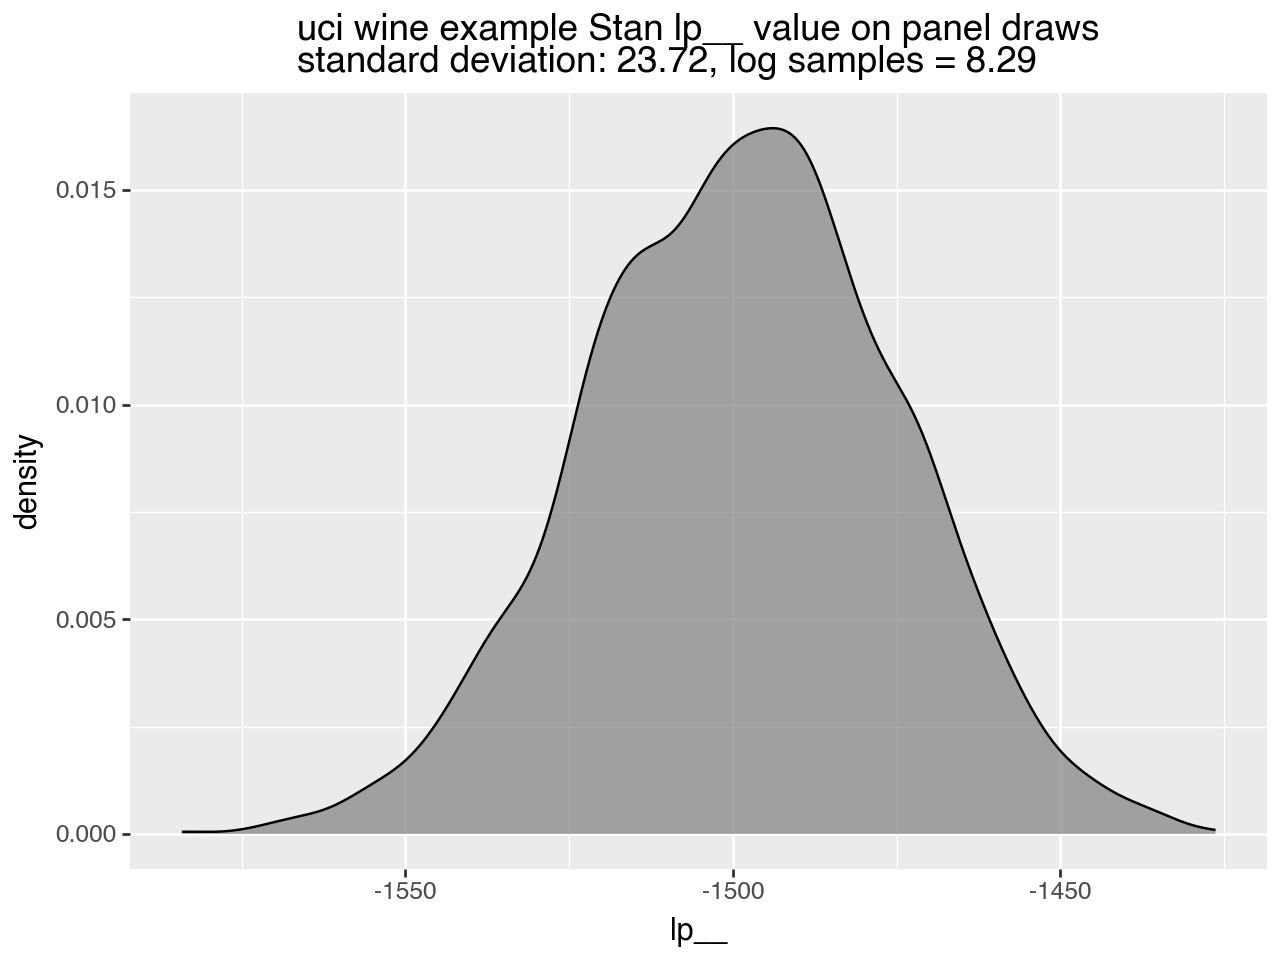

In [28]:
if do_display:
    stddev = np.sqrt(np.var(wt_frame["lp__"]))
    log_samples = np.log(wt_frame.shape[0])
    (
        ggplot(
            data=wt_frame,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on panel draws\nstandard deviation: {stddev:.2f}, log samples = {log_samples:.2f}"
        )
    ).show()

In [29]:
beta_draws = fit.draws_pd(vars=["beta"])
beta_draws_display = beta_draws.copy()
beta_draws_display.columns = list(features_frame.columns) + [
    f"position_effect_{sel_i}" for sel_i in range(n_alternatives)
]

beta_draws_display

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,density is white,pH is white,sulphates is white,alcohol is white,is_red,position_effect_0,position_effect_1,position_effect_2,position_effect_3,position_effect_4
0,0.593172,-10.20150,-7.041390,0.588957,-11.865000,-0.092549,0.049328,-5.462830,4.293310,6.62343,...,4.83995,-0.268911,-1.553270,2.82376,1.58728,10.31250,4.45603,1.766750,0.645126,-3.629160
1,1.730720,-16.05160,-10.432900,0.618645,-4.383990,0.033204,0.010059,-5.979850,6.965800,2.72872,...,4.15092,-2.498850,2.903330,2.46475,-11.21620,9.69770,4.56228,2.565170,-0.796490,-3.336610
2,0.825862,-4.87325,-3.140610,0.277632,-10.490600,0.087255,-0.021885,-2.803270,0.357082,5.07715,...,1.39707,2.410720,0.890638,2.85115,4.04114,7.33144,2.28537,-1.454370,-4.850550,-5.561530
3,0.675961,-3.85046,-3.211050,0.101614,-11.155500,0.117465,-0.025847,-5.542930,-1.849210,5.42734,...,-2.81009,2.135430,0.809144,2.67987,5.42380,8.08236,3.44798,-1.379850,-2.504320,-6.252290
4,0.600274,-2.70329,0.815393,0.389506,-14.964100,0.105768,-0.018261,18.375600,-3.081640,8.15357,...,4.86834,4.836930,0.904460,2.54245,-10.16320,6.75755,1.36835,-1.690730,-4.891930,-7.584180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.219611,-8.22634,-1.447940,-0.067611,0.846885,0.097939,0.007813,-7.023420,2.595500,4.11957,...,1.64539,0.928956,5.072150,2.52402,1.34238,6.13332,1.42901,-3.348320,-5.218940,-5.999780
3996,1.663920,-11.06530,-17.213200,0.919362,-10.610100,0.148911,-0.024135,2.012630,-1.874510,11.38120,...,3.94570,-0.177363,3.167980,2.33221,-2.82757,9.48150,4.49116,0.995787,-0.810612,-4.913270
3997,0.642389,-14.32540,1.159600,0.423756,-11.046000,0.110437,-0.014824,-3.725330,5.453000,1.14048,...,-10.50260,4.464940,1.024150,2.67554,4.93985,12.54730,7.42406,3.798000,0.970319,-0.802549
3998,1.097360,-11.02490,-8.916540,0.188726,-3.009920,0.053962,-0.026720,-7.207410,2.123980,4.61202,...,-7.08433,1.252030,-1.576430,2.63397,1.04330,9.09570,3.56783,0.255154,-3.214110,-3.754380


In [30]:
# this this entirety of what we pull out of Stan- per modeled preference cohort
# from now on we do not use Stan
estimated_beta_Stan = beta_draws_display.loc[
    wt_frame["lp__"] >= np.quantile(wt_frame["lp__"], 0.5), :
].mean()
# estimated_beta_Stan = beta_draws_display.mean()
estimated_beta_Stan

fixed acidity is red              1.237448
volatile acidity is red         -10.248654
citric acid is red               -7.976978
residual sugar is red             0.510525
chlorides is red                 -5.400632
free sulfur dioxide is red        0.099456
total sulfur dioxide is red      -0.004969
density is red                   -3.626767
pH is red                         2.654523
sulphates is red                  4.988724
alcohol is red                    1.972951
fixed acidity is white           -0.240286
volatile acidity is white        -8.244427
citric acid is white             -2.284331
residual sugar is white           0.124301
chlorides is white               -0.244286
free sulfur dioxide is white      0.032323
total sulfur dioxide is white     0.009517
density is white                  3.519511
pH is white                       0.381080
sulphates is white                2.769084
alcohol is white                  2.648743
is_red                           -3.816524
position_ef

picks


,row,position,pick probability estimate,was pick
0,0,0,0.7633,False
1,0,1,0.0373,False
2,0,2,0.0582,False
3,0,3,0.0288,False
4,0,4,0.1124,True
5,1,0,0.4359,True
6,1,1,0.1441,False
7,1,2,0.2448,False
8,1,3,0.0672,False
9,1,4,0.1080,False


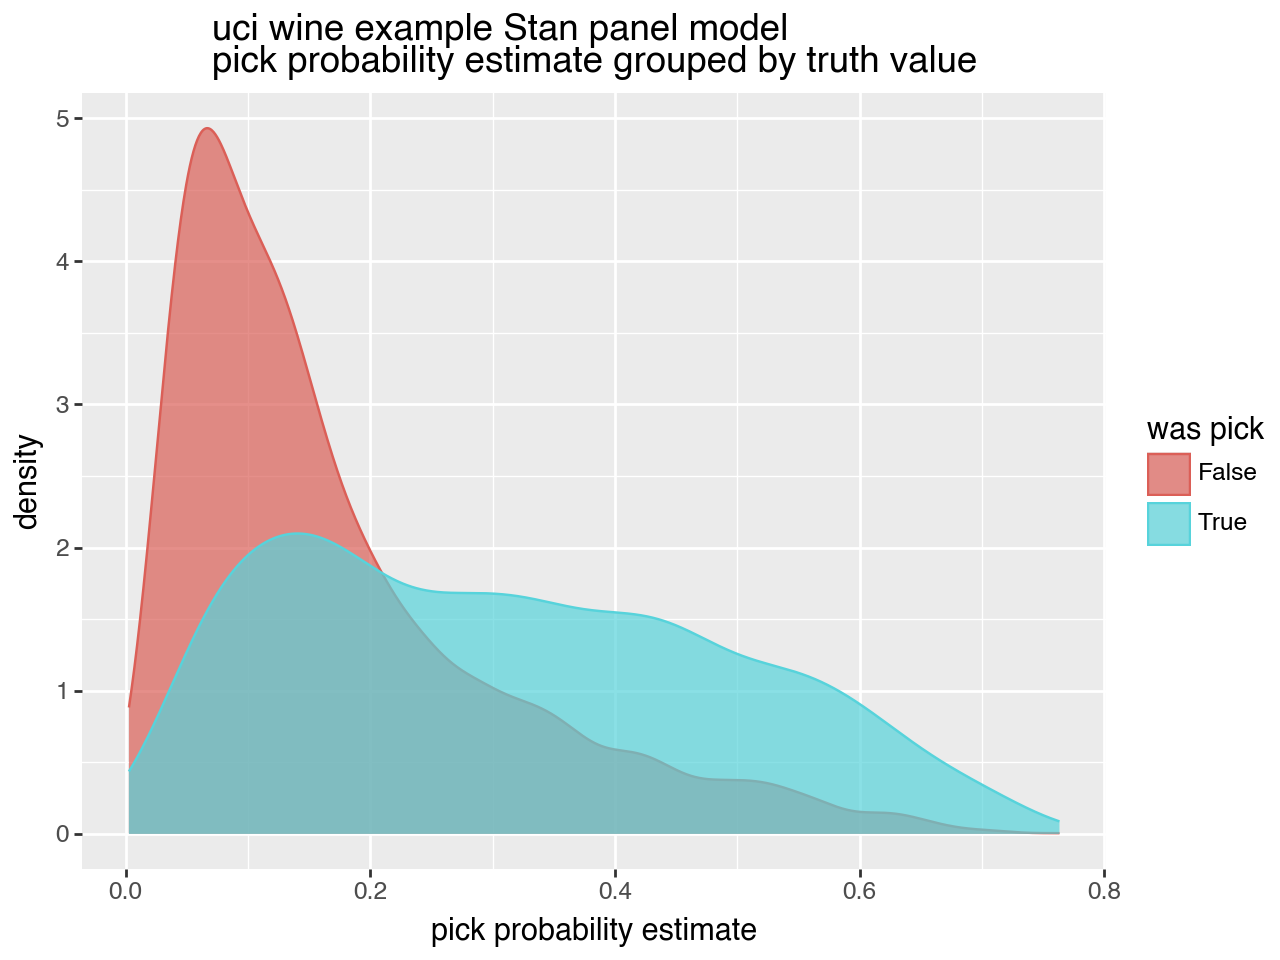

<Figure size 640x480 with 0 Axes>

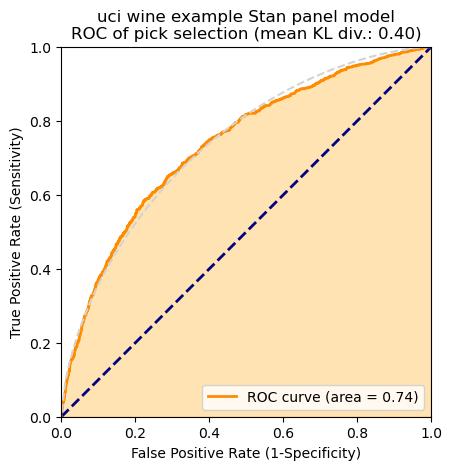

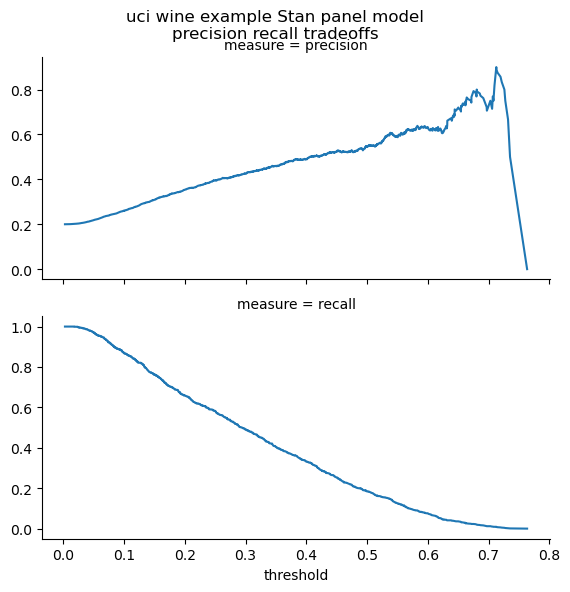

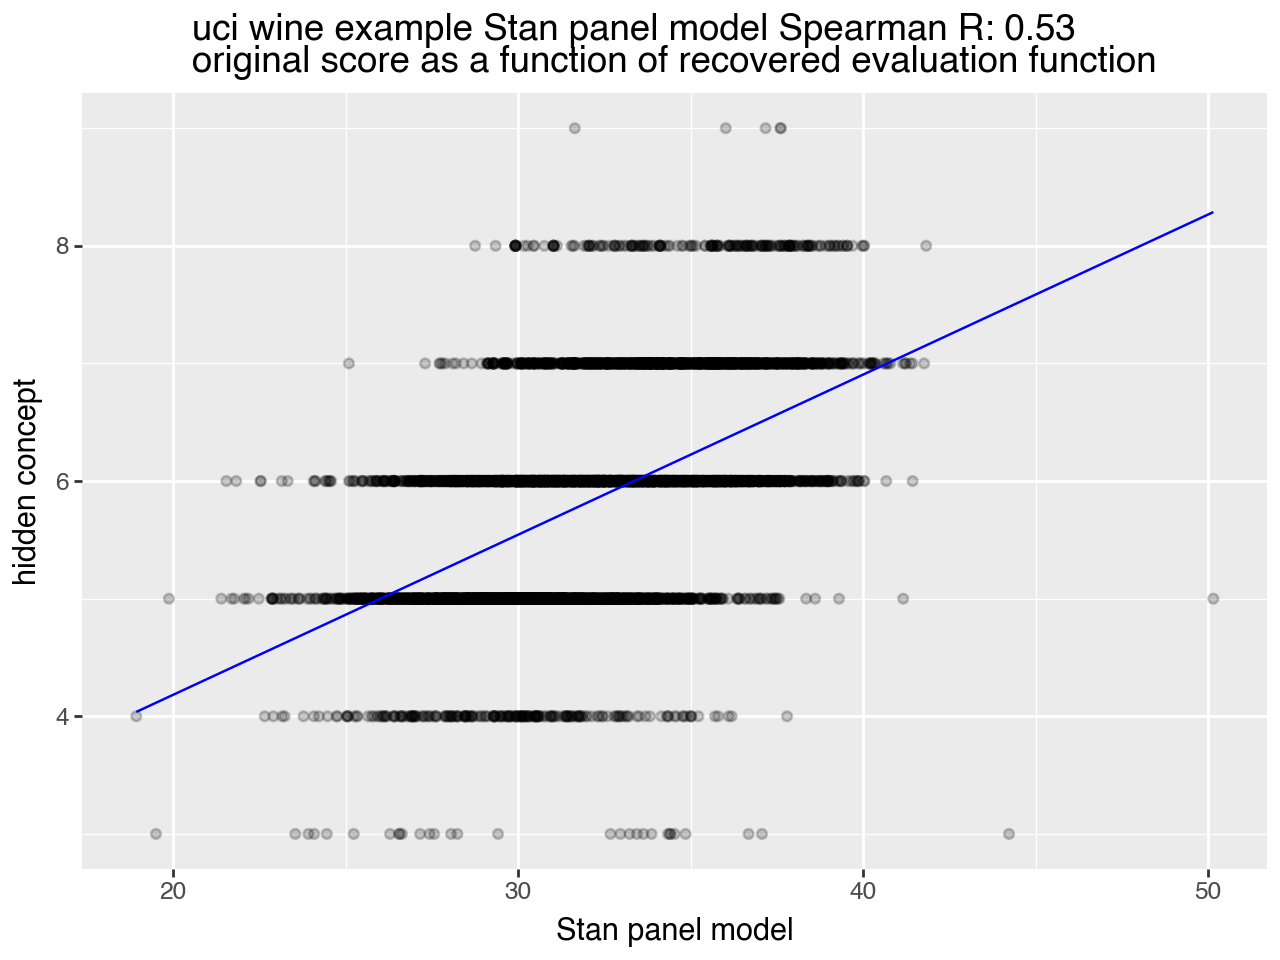

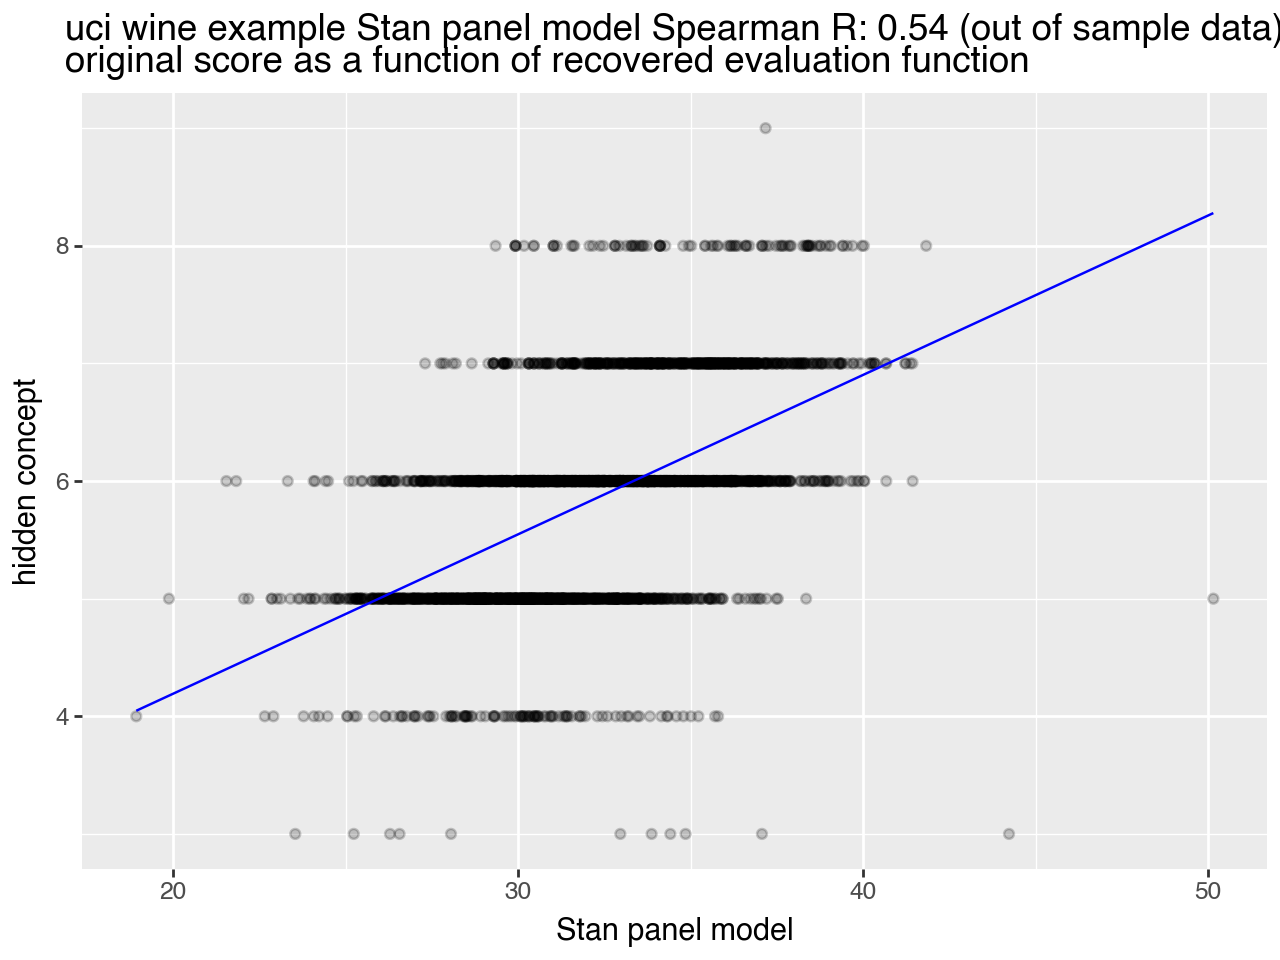

In [31]:
stat_pull = plot_rank_performance(
    model=estimated_beta_Stan,  # estimated coefficients
    model_type='coef',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name="Stan panel model",  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

Try to approximate the Stan model with a classification model with similar error structure.
Consider each pair of panel entries with a different outcome as an observation and try to
build a model that reproduces the observed outcomes.
The extra trick is: repeat the whole data frame negated with the outcomes reverse (so 
we don't define a problem with all positive or all negative outcomes).


In [32]:
encode_position: bool = True
feature_names = list(features_frame.columns)
sample_weight = None
if encode_position:
    feature_names = feature_names +[
        f"position_{sel_i}" for sel_i in range(n_alternatives)
    ]
else:
    sample_weight = []
enc_frame = []
for row_i in range(observations_train.shape[0]):
    feature_row = observations_train.loc[row_i, :]
    sel_pick = np.argmax(
        feature_row[[f"pick_value_{sel_i}" for sel_i in range(n_alternatives)]]
    )
    for sel_i in range(n_alternatives):
        if sel_i != sel_pick:
            encoded_row = list(
                    features_frame.loc[feature_row[f"item_id_{sel_pick}"], :]
                    - features_frame.loc[feature_row[f"item_id_{sel_i}"], :]
                )
            if encode_position:
                posn_vec = [0] * n_alternatives
                posn_vec[sel_pick] = 1.0
                posn_vec[sel_i] = -1.0
                encoded_row = encoded_row + posn_vec  
            if sample_weight is not None:
                # TODO: use sel_wt for conjugate row
                sample_weight.append(1.0 / win_frequencies.loc[sel_pick, 'win frequency'])
            di = pd.DataFrame({k: [v] for k, v in zip(feature_names, encoded_row)})
            enc_frame.append(di)
enc_frame = pd.concat(enc_frame, ignore_index=True)

In [33]:
classification_model = LogisticRegression(max_iter=10000, solver="newton-cholesky")
classification_model_name = 'logistic'

# classification_model = XgboostClassifier(rng=rng)
# classification_model_name = 'xgboost'

# classification_model = RandomForestClassifier()
# classification_model_name = 'Random Forest'

In [34]:
if sample_weight is not None:
    classification_model.fit(
        X=pd.concat([enc_frame, -enc_frame], ignore_index=True),
        y=[True] * enc_frame.shape[0] + [False] * enc_frame.shape[0],
        sample_weight=sample_weight + sample_weight,
    )
else:
    classification_model.fit(
        X=pd.concat([enc_frame, -enc_frame], ignore_index=True),
        y=[True] * enc_frame.shape[0] + [False] * enc_frame.shape[0],
    )

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2702,False
1,0,1,0.1708,False
2,0,2,0.1874,False
3,0,3,0.1661,False
4,0,4,0.2055,True
5,1,0,0.2351,True
6,1,1,0.1925,False
7,1,2,0.2054,False
8,1,3,0.1752,False
9,1,4,0.1918,False


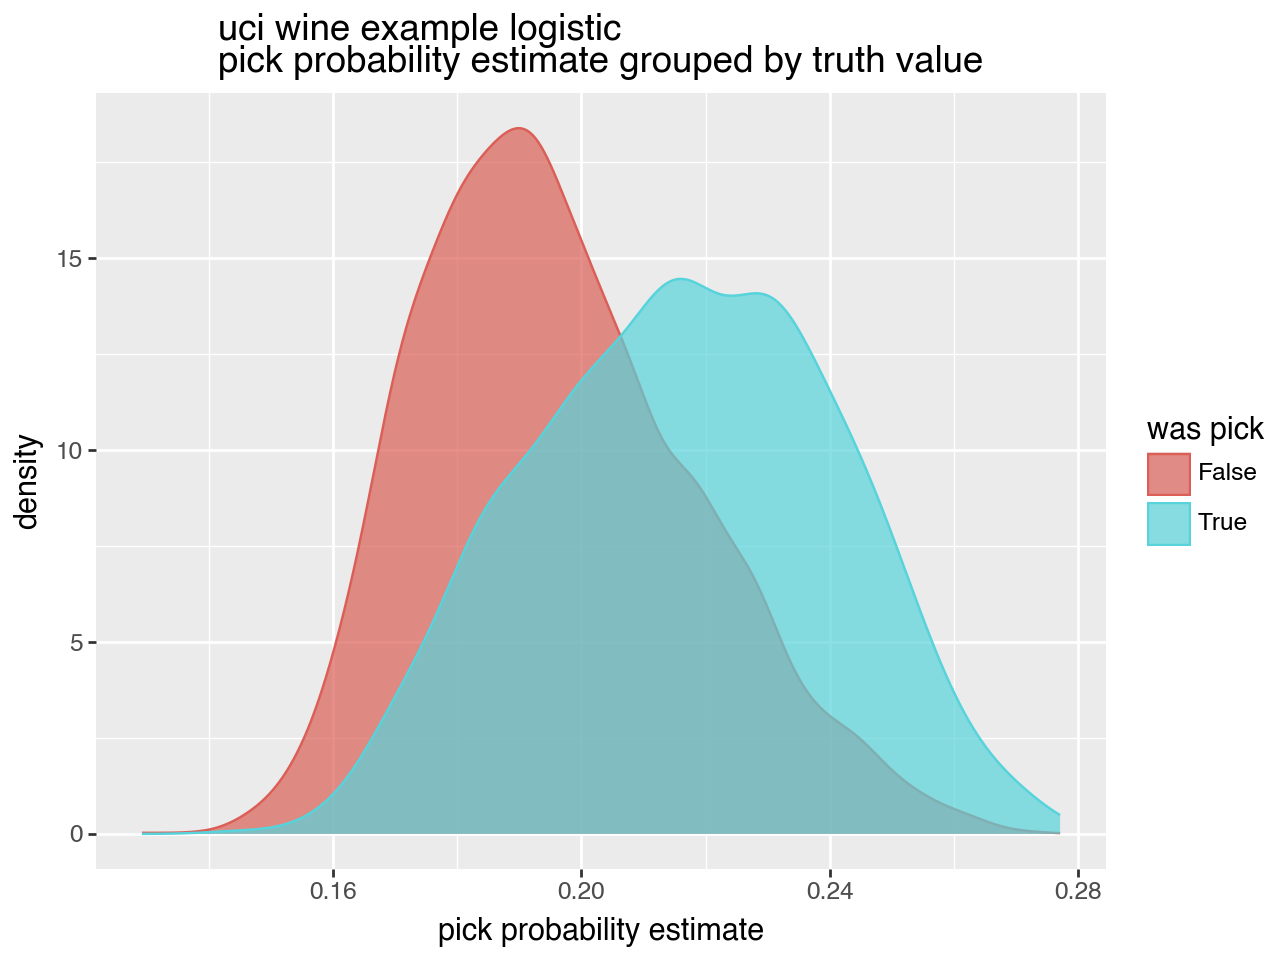

<Figure size 640x480 with 0 Axes>

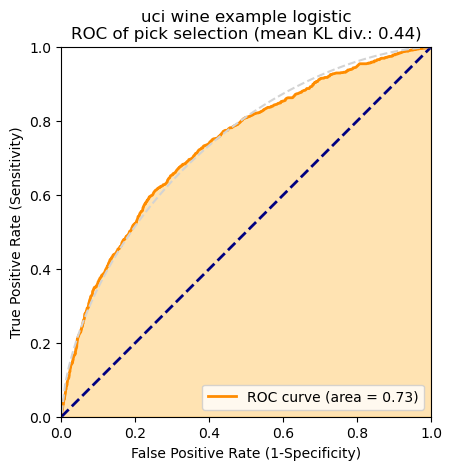

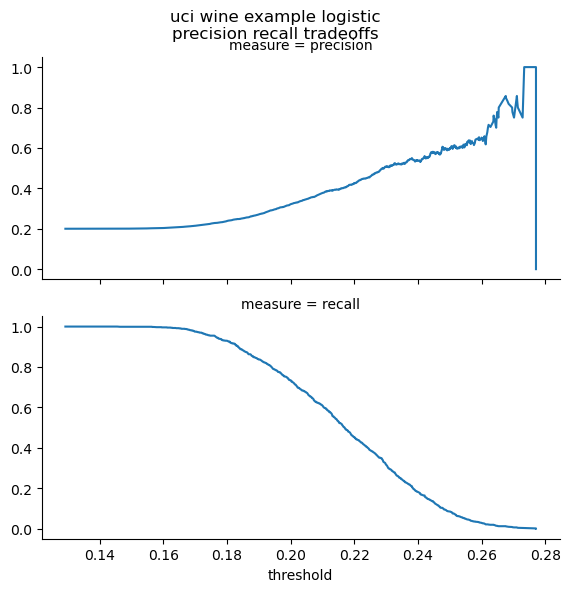

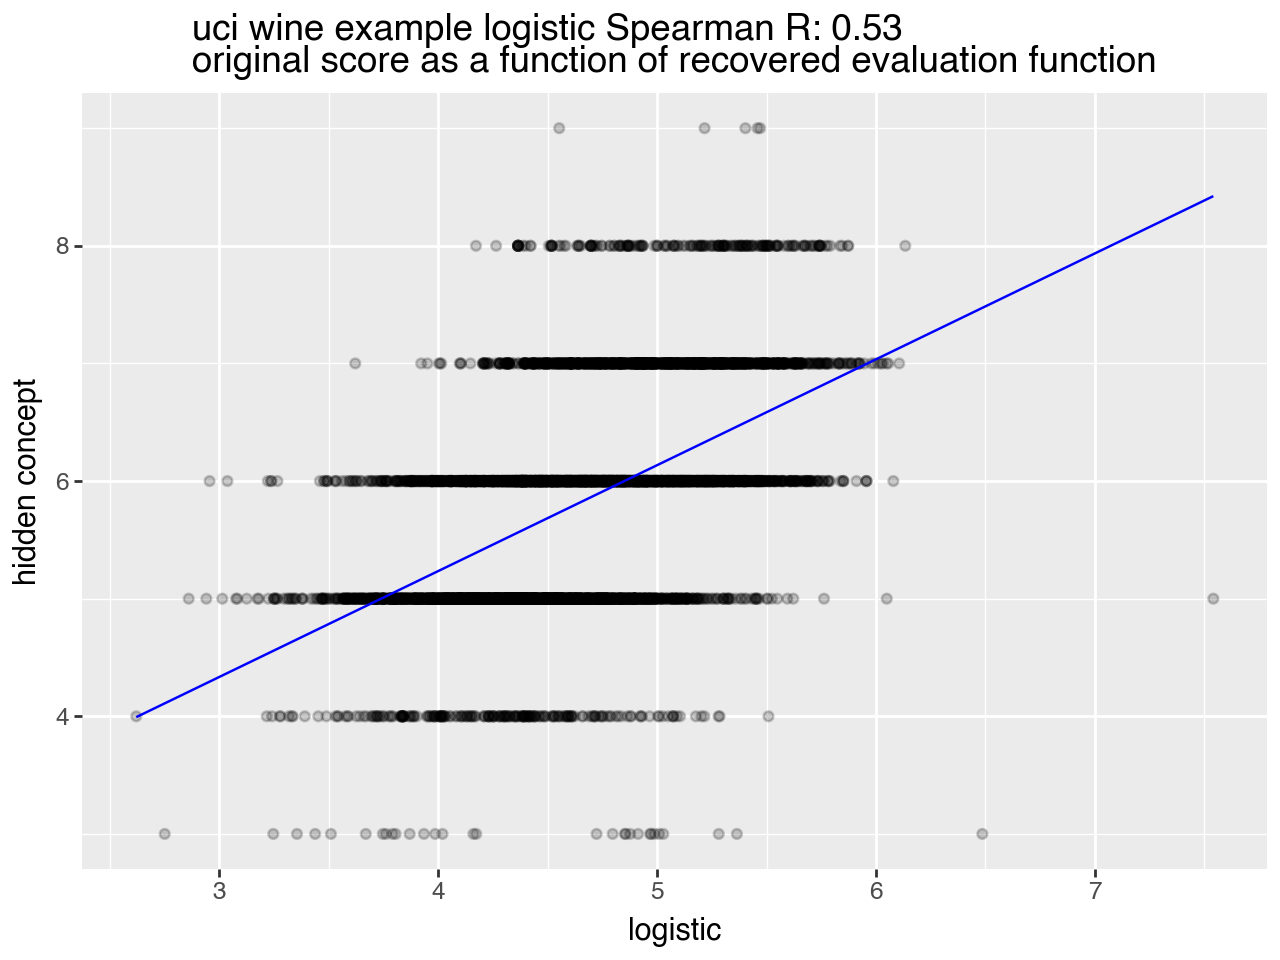

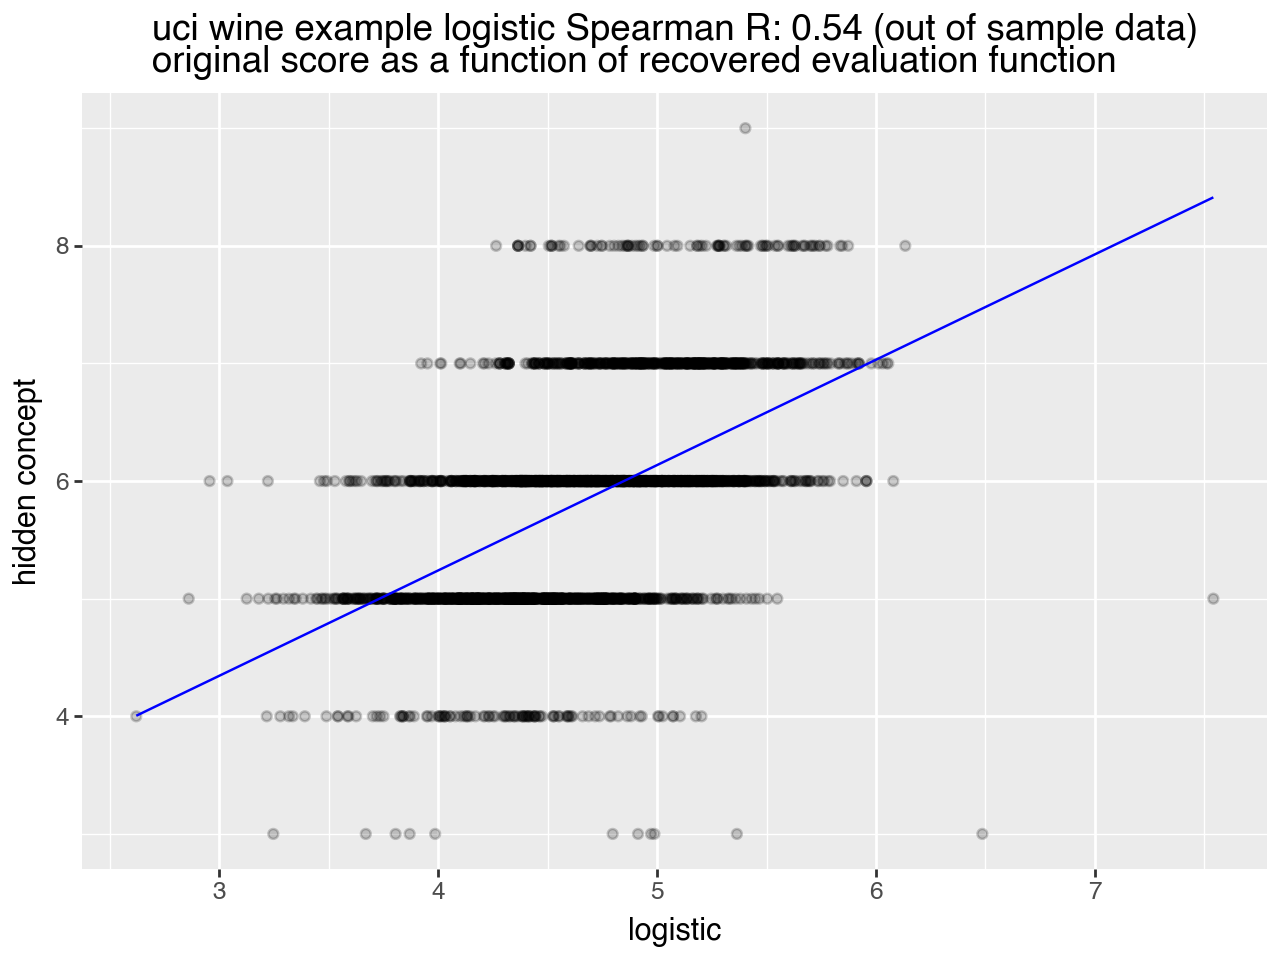

In [35]:
stat_pull = plot_rank_performance(
    model=classification_model,
    model_type='classifier',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name=classification_model_name,  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

We can also try a related Stan model per-comparison, instead of per-panel.

In [36]:
stan_model_comparison_src = define_Stan_choice_src(n_alternatives=n_alternatives)

if do_display:
    print(stan_model_comparison_src)


data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;   // character of passed examples
}
parameters {
  vector[n_vars] beta;                      // model parameters
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] expect_passed_1;
  vector[m_examples] expect_passed_2;
  vector[m_examples] expect_passed_3;
  vector[m_examples] expect_passed_4;
  expect_picked = x_picked * beta;          // modeled expected score of picked item
  expect_passed_1 = x_passed_1 * beta;      // modeled expected score of passed item
  expe

In [37]:
fit_comp = run_stan_model(
    stan_model_src=stan_model_comparison_src,
    data_str=data_str,
)

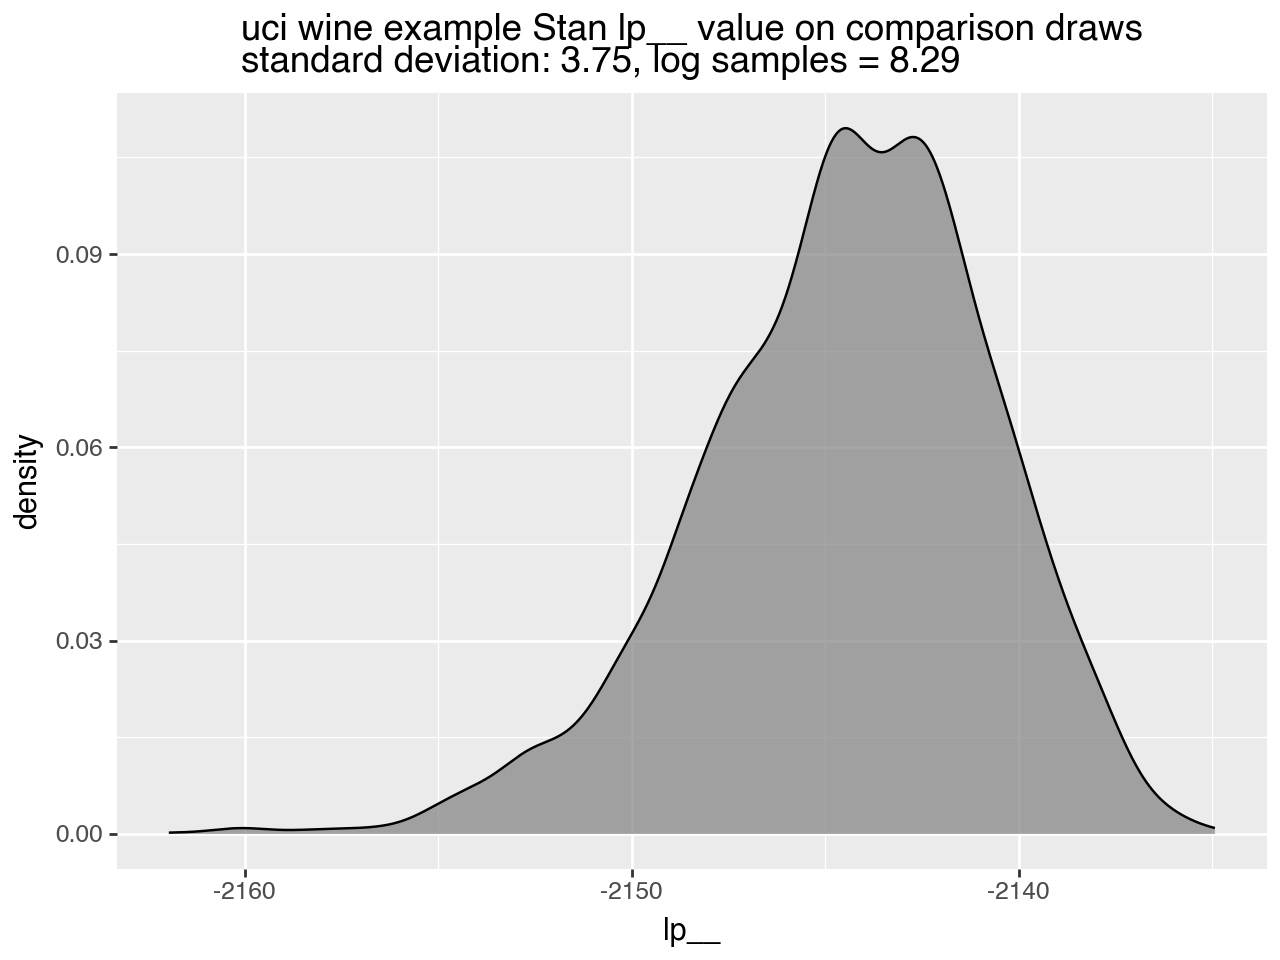

In [38]:
# get implied sample weights from chain
wt_frame_c = fit_comp.draws_pd(vars=["lp__"])
if do_display:
    stddev_c = np.sqrt(np.var(wt_frame_c["lp__"]))
    log_samples_c = np.log(wt_frame_c.shape[0])
    (
        ggplot(
            data=wt_frame_c,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on comparison draws\nstandard deviation: {stddev_c:.2f}, log samples = {log_samples_c:.2f}"
        )
    ).show()

In [39]:
beta_draws_c = fit_comp.draws_pd(vars=["beta"])
estimated_beta_Stan_c = beta_draws_c.loc[
    wt_frame_c["lp__"] >= np.quantile(wt_frame_c["lp__"], 0.5), :
].mean()
# estimated_beta_Stan_c = beta_draws_c.mean()

picks


,row,position,pick probability estimate,was pick
0,0,0,0.8661,False
1,0,1,0.0175,False
2,0,2,0.0362,False
3,0,3,0.0130,False
4,0,4,0.0672,True
5,1,0,0.4885,True
6,1,1,0.1270,False
7,1,2,0.2491,False
8,1,3,0.0469,False
9,1,4,0.0885,False


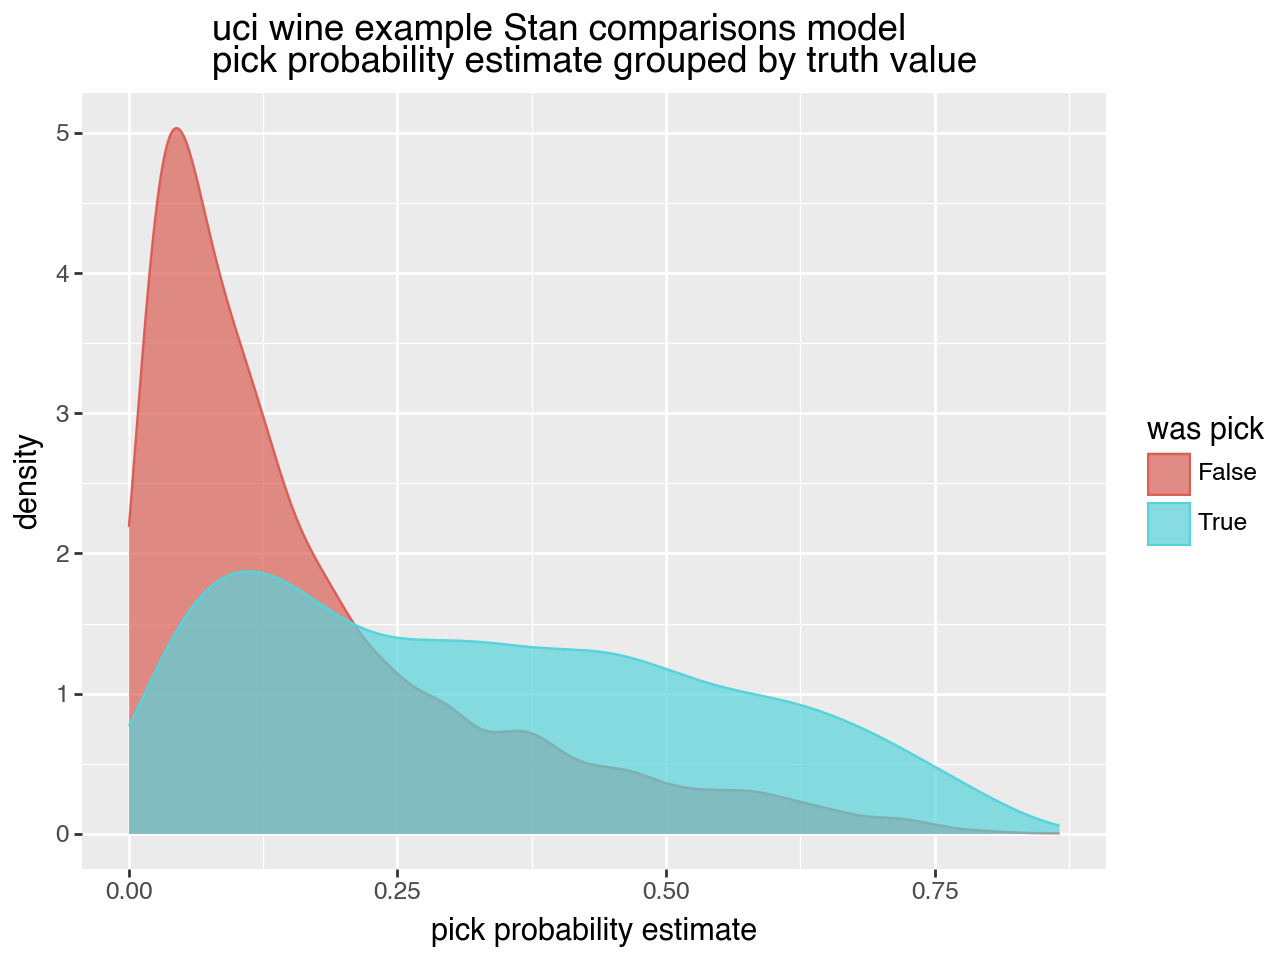

<Figure size 640x480 with 0 Axes>

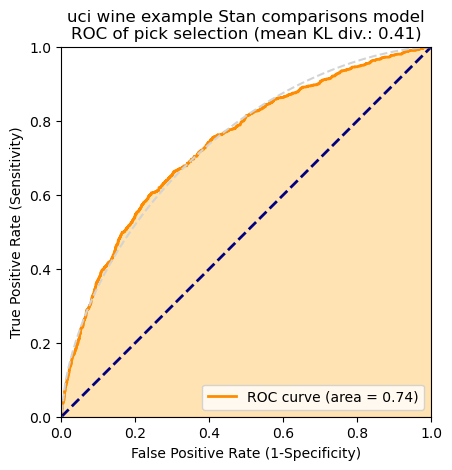

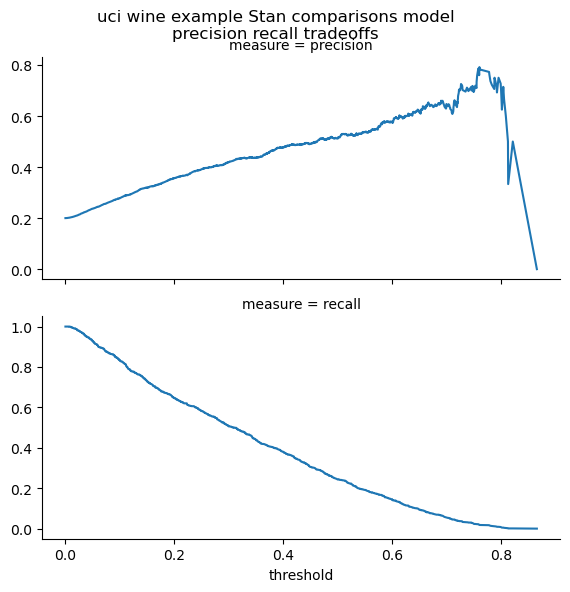

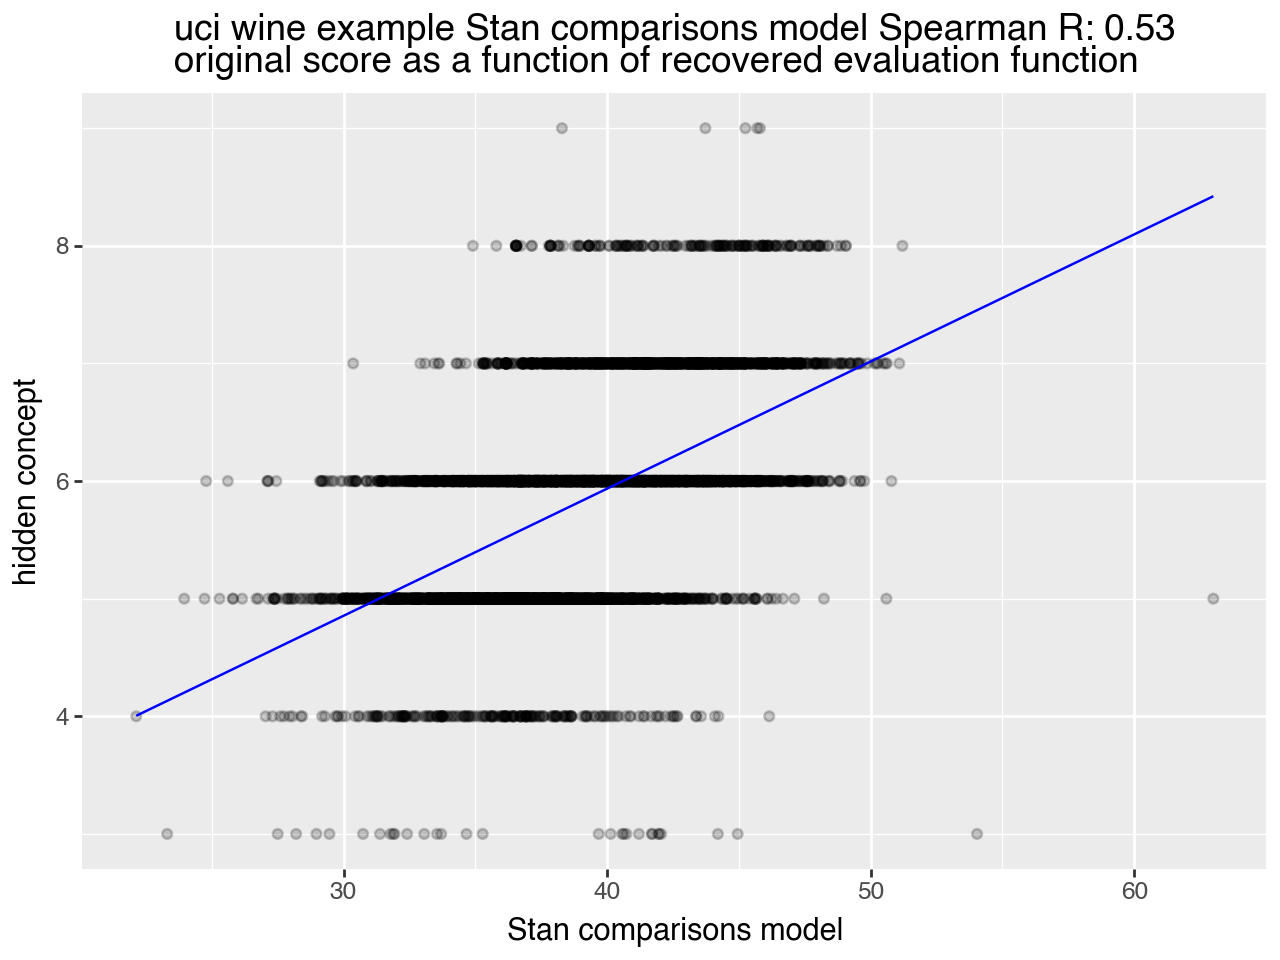

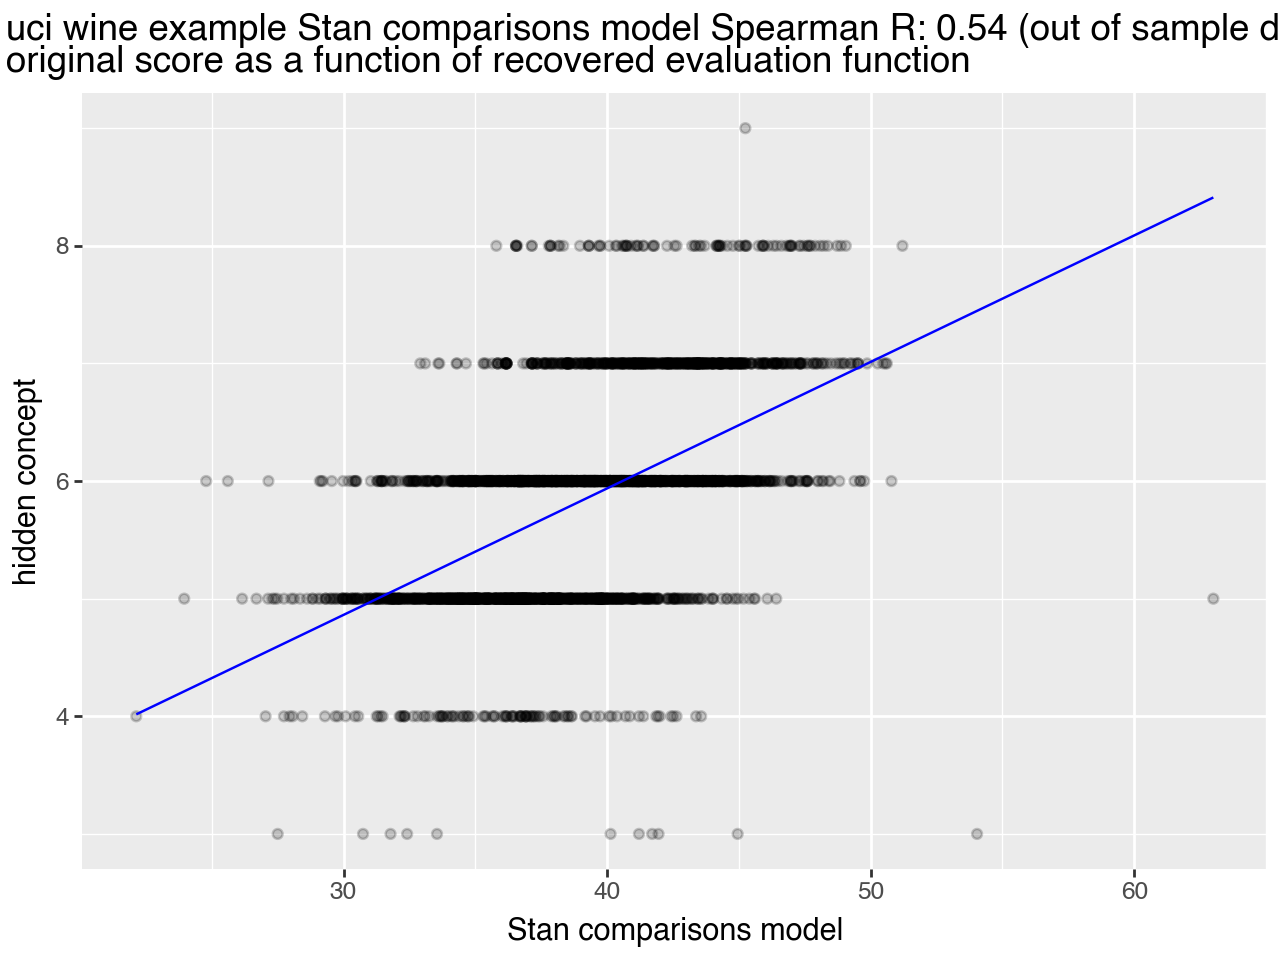

In [40]:
stat_pull = plot_rank_performance(
    model=estimated_beta_Stan_c,  # estimated coefficients
    model_type='coef',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name="Stan comparisons model",  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2255,False
1,0,1,0.1703,False
2,0,2,0.1921,False
3,0,3,0.1942,False
4,0,4,0.2179,True
5,1,0,0.1937,True
6,1,1,0.1960,False
7,1,2,0.2069,False
8,1,3,0.1994,False
9,1,4,0.2040,False


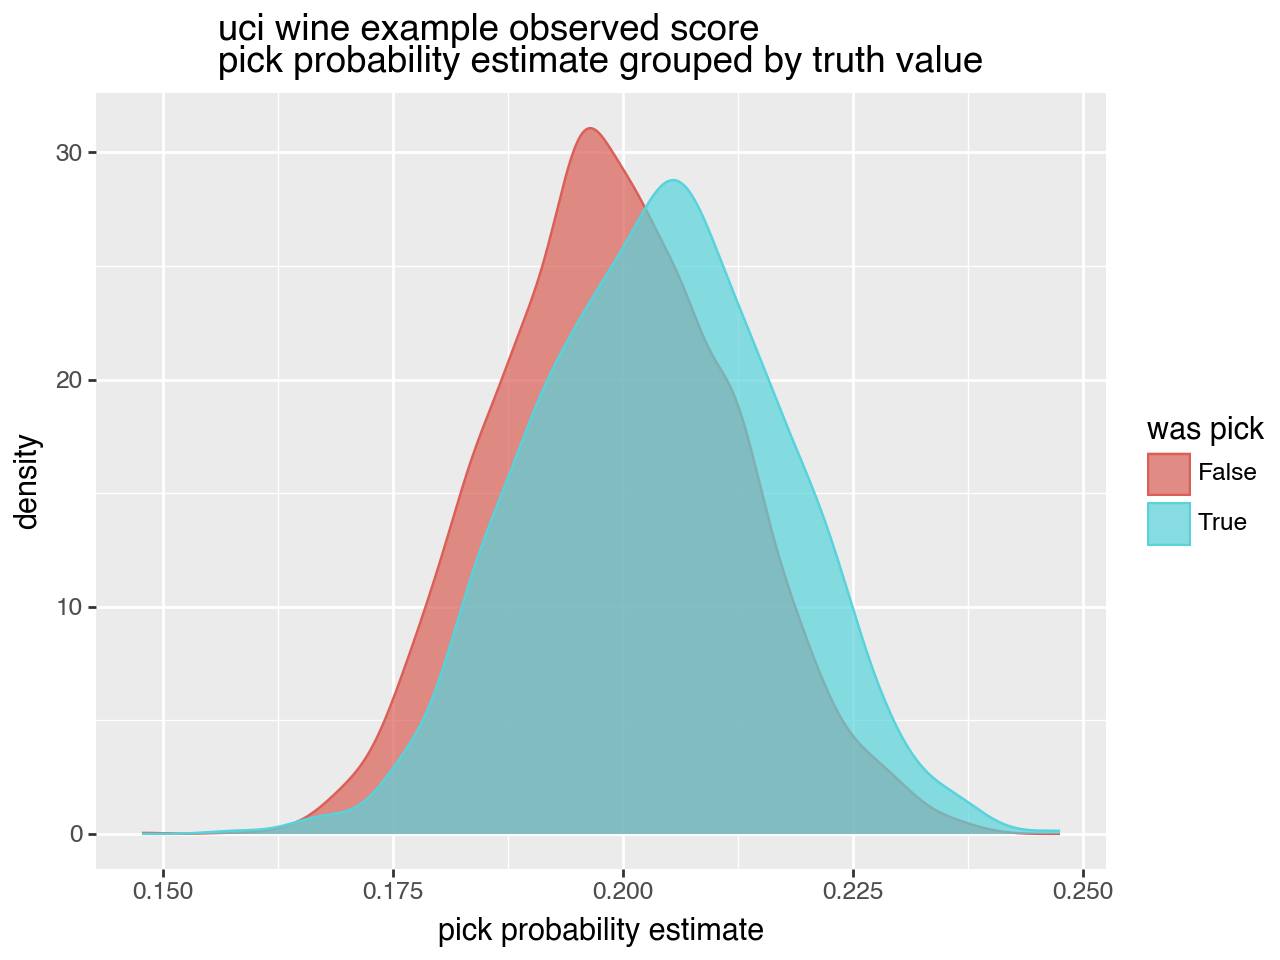

<Figure size 640x480 with 0 Axes>

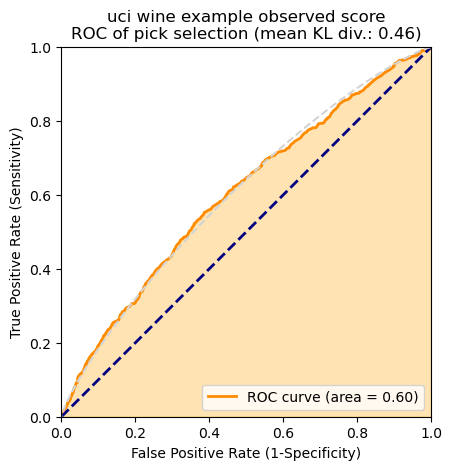

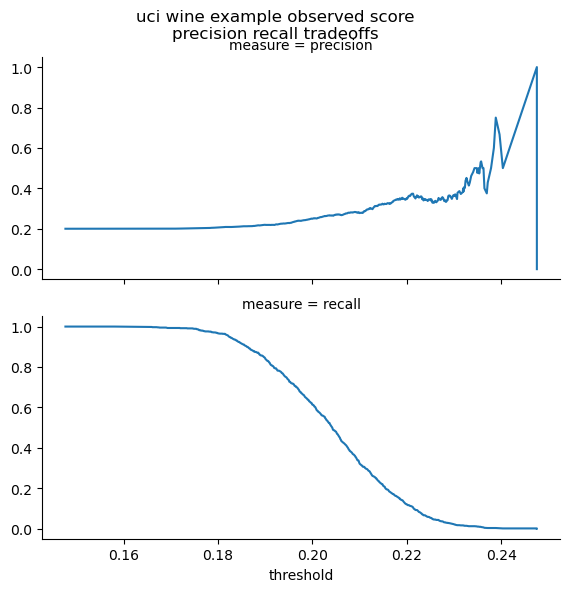

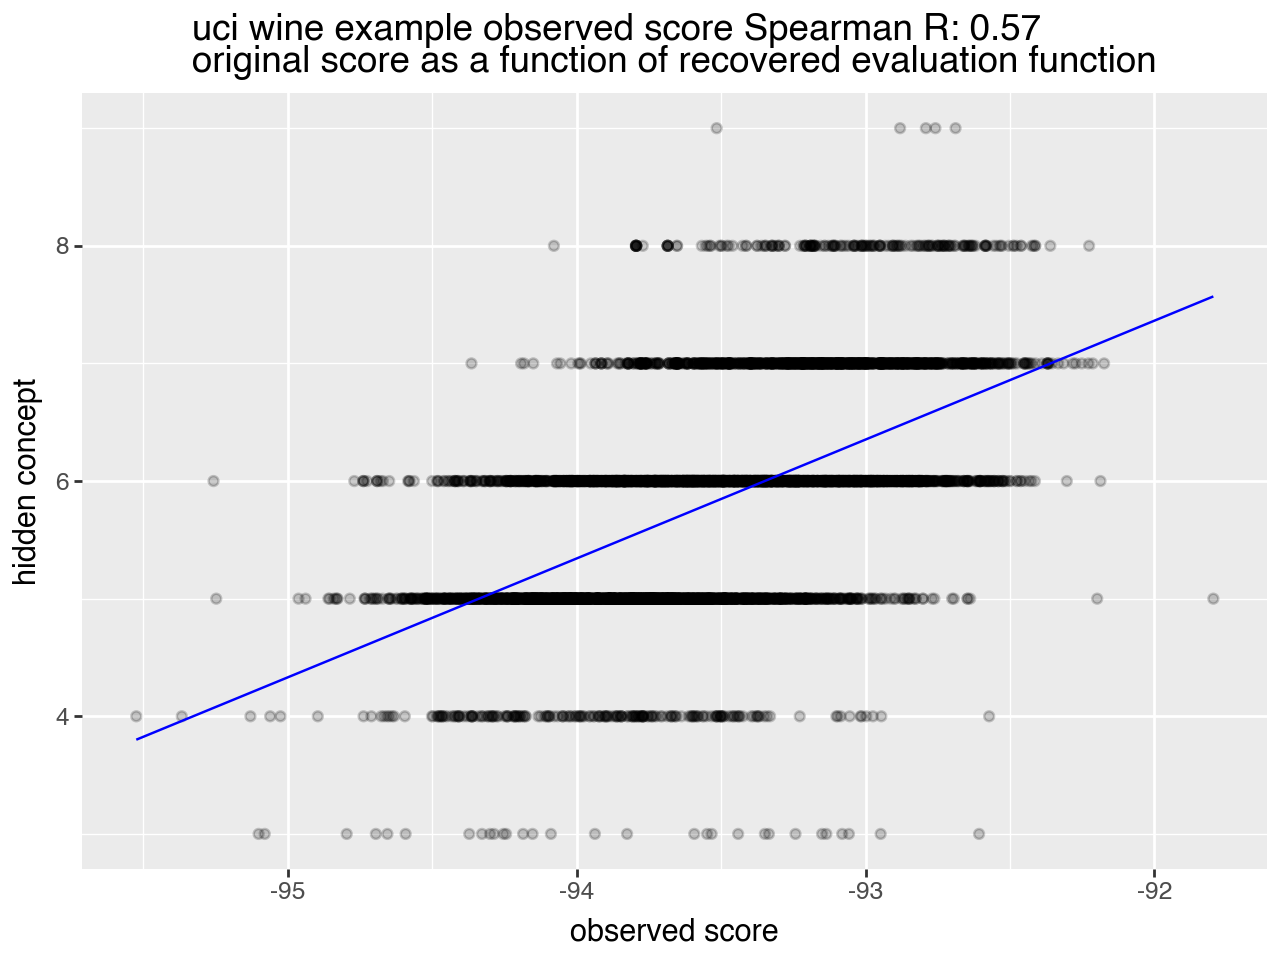

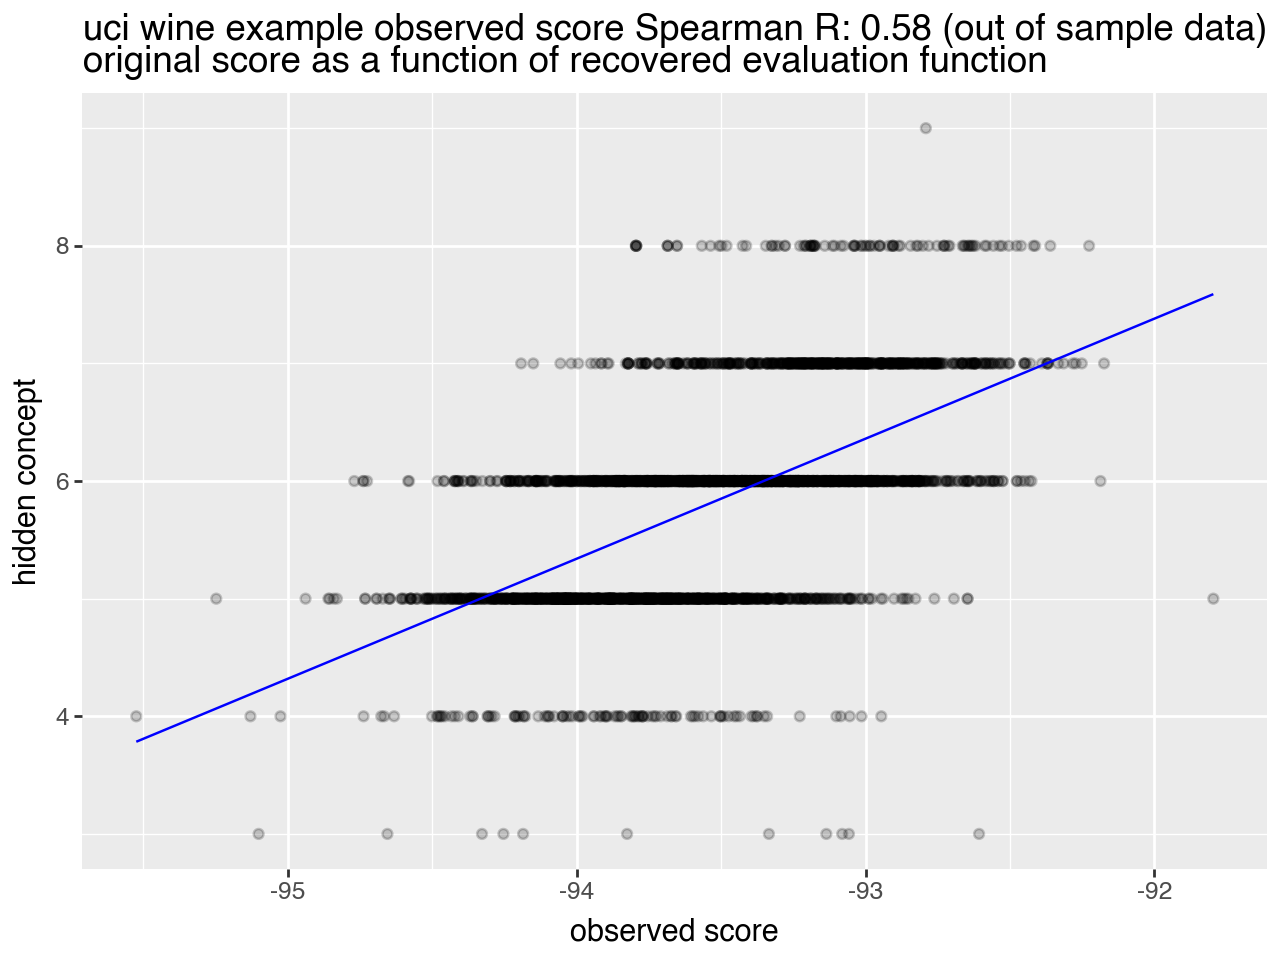

In [41]:
# plug in the perfect model that saw the scores
if know_score and (perfect_coef is not None):
    perfect_pull = plot_rank_performance(
        model=perfect_coef,  # estimated coefficients
        model_type='coef',  # TODO pass regression model directly
        example_name=example_name,  # name of data set
        n_alternatives=n_alternatives,  # size of panels
        features_frame=features_frame,  # features by row id
        observations_train=observations_train,  # training observations layout frame
        observations_test=observations_test,  # evaluation observations layout frame
        estimate_name="observed score",  # display name of estimate
        score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
        rng=rng,  # pseudo random source
        show_plots=do_display,
    )
    collected_stats.append(perfect_pull)

In [42]:
collected_stats = pd.concat(collected_stats, ignore_index=True)
# collected_stats['perfect_model_SpearmanR'] = perfect_model_SpearmanR

In [43]:
if (result_fname is not None) and (len(result_fname) > 0):
    collected_stats.to_csv(result_fname, index=False)

In [44]:
if do_display:
    display(collected_stats)

,example_name,estimate_name,SpearmanR_all,SpearmanR_test,pick_auc,mean pick KL divergence,training panels,test panels,data_size,test_size
0,uci wine example,Stan panel model,0.530817,0.536988,0.737457,0.399115,1000,1000,6497,3000
1,uci wine example,logistic,0.533531,0.539997,0.733414,0.443515,1000,1000,6497,3000
2,uci wine example,Stan comparisons model,0.533230,0.539499,0.735768,0.408330,1000,1000,6497,3000
3,uci wine example,observed score,0.570074,0.579847,0.602680,0.459544,1000,1000,6497,3000
